# Business Goal
The primary business goal of this research is to enhance the efficiency and accuracy of the credit card approval process. By developing a robust machine learning model, the aim is to achieve the following key objectives:

1.	Improve Approval Accuracy: Increase the precision of approval decisions, ensuring that eligible applicants are accurately identified and approved while minimizing the risk of approving ineligible applicants.
2.	Reduce Operational Costs: Streamline the approval process by automating initial screening, thereby reducing manual workload, decreasing processing times, and lowering overall operational costs.
3.	Enhance Customer Experience: Provide a faster and more seamless application experience for customers by reducing the time required for application assessment and decision-making.
4.	Mitigate Risk: Implement data-driven decision-making to mitigate the risk associated with defaults and fraud by accurately assessing the creditworthiness of applicants.
5.	Increase Market Share: Leverage the insights gained from the predictive model to target and acquire a broader base of qualified applicants, ultimately increasing the institution’s market share in the competitive financial services sector.

By achieving these goals, the research aims to provide actionable insights and a scalable solution that aligns with the strategic objectives of the organization, fostering growth, customer satisfaction, and financial stability.

# Index

- [Data preparation](#dataprep)
- [Data Analysis](#data_analysis)
- [Model Selection](#model)
- [Conclusion](#conclusion)


# Data preparation<a id="dataprep"></a>

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from xgboost import XGBClassifier

In [49]:
import warnings
warnings.filterwarnings("ignore")

### Read data sets

In [2]:
# Load the data from zip file
application_df = pd.read_csv('data/application_record.zip')
credit_df = pd.read_csv('data/credit_record.zip')

### Construct target label

In [3]:
credit_df.sample(5)

,ID,MONTHS_BALANCE,STATUS
94999,5008944,-19,0
134678,5011219,-26,X
801647,5115519,-22,0
793749,5114300,-14,X
519083,5061843,-45,0


***Content explanation***
* ID - Client number	　
* MONTHS_BALANCE - Record month	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
* STATUS	Status	0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

In [4]:
# count unique ids in credit_df
cred_uids = credit_df['ID'].nunique()

# count unique ids in application_df
app_uids = application_df['ID'].nunique()

print(f'Unique IDs in credit_df: {cred_uids}')
print(f'Unique IDs in application_df: {app_uids}')

Unique IDs in credit_df: 45985
Unique IDs in application_df: 438510


Here we can see that credit records contain fewer unique IDs compared to application records. However, we need to filter credit records further.

To build a target label we will use the following strategy:
* "Bad" client - anyone who has records with 30 days overdue or more in the last two years
* "Good" client - anyone who has a credit record history for the last 2 years and no overdue over 30 days

Clients who don't match good or bad criteria will be ignored.

In [5]:
valid_credit_records = credit_df[credit_df['MONTHS_BALANCE'] >= -24]

print(f'Clients with a valid credit history: {valid_credit_records["ID"].nunique()}')

Clients with a valid credit history: 42596


In [6]:
# select all applications records that has id in valid_credit_records
valid_applications = application_df[application_df['ID'].isin(valid_credit_records['ID'])]

In [8]:
print(f'Amount of valid applications: {valid_applications["ID"].nunique()}')

Amount of valid applications: 33068


In [9]:
# add a column to valid_applications that indicates if the client is good or bad
valid_applications['STATUS'] = 1 # good
valid_applications.loc[valid_applications['ID'].isin(credit_df[credit_df['STATUS'].isin(['1','2','3','4', '5'])]['ID']), 'STATUS'] = 0 # bad

/var/folders/rz/d543tms9543f_v11vps9f2s00000gp/T/ipykernel_4301/333513147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_applications['STATUS'] = 1 # good


In [10]:
valid_applications.shape

(33068, 19)

As a result of target label construction, we have about 33k records and 18 features in our data set.

# Data Analysis <a class="anchor" id="data_analysis"></a>

In [15]:
# inspect the data
valid_applications.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1


In [16]:
valid_applications.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33068 entries, 0 to 434812
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   33068 non-null  int64  
 1   CODE_GENDER          33068 non-null  object 
 2   FLAG_OWN_CAR         33068 non-null  object 
 3   FLAG_OWN_REALTY      33068 non-null  object 
 4   CNT_CHILDREN         33068 non-null  int64  
 5   AMT_INCOME_TOTAL     33068 non-null  float64
 6   NAME_INCOME_TYPE     33068 non-null  object 
 7   NAME_EDUCATION_TYPE  33068 non-null  object 
 8   NAME_FAMILY_STATUS   33068 non-null  object 
 9   NAME_HOUSING_TYPE    33068 non-null  object 
 10  DAYS_BIRTH           33068 non-null  int64  
 11  DAYS_EMPLOYED        33068 non-null  int64  
 12  FLAG_MOBIL           33068 non-null  int64  
 13  FLAG_WORK_PHONE      33068 non-null  int64  
 14  FLAG_PHONE           33068 non-null  int64  
 15  FLAG_EMAIL           33068 non-null  int

#### Content explanation

| Feature name        | Explanation              | Remarks                                                                                     |
|---------------------|--------------------------|---------------------------------------------------------------------------------------------|
| ID                  | Client number            |                                                                                             |
| CODE_GENDER         | Gender                   |                                                                                             |
| FLAG_OWN_CAR        | Is there a car           |                                                                                             |
| FLAG_OWN_REALTY     | Is there a property      |                                                                                             |
| CNT_CHILDREN        | Number of children       |                                                                                             |
| AMT_INCOME_TOTAL    | Annual income            |                                                                                             |
| NAME_INCOME_TYPE    | Income category          |                                                                                             |
| NAME_EDUCATION_TYPE | Education level          |                                                                                             |
| NAME_FAMILY_STATUS  | Marital status           |                                                                                             |
| NAME_HOUSING_TYPE   | Way of living            |                                                                                             |
| DAYS_BIRTH          | Birthday                 | Count backwards from current day (0), -1 means yesterday                                    |
| DAYS_EMPLOYED       | Start date of employment | Count backwards from current day(0). If positive, it means the person currently unemployed. |
| FLAG_MOBIL          | Is there a mobile phone  |                                                                                             |
| FLAG_WORK_PHONE     | Is there a work phone    |                                                                                             |
| FLAG_PHONE          | Is there a phone         |                                                                                             |
| FLAG_EMAIL          | Is there an email        |                                                                                             |
| OCCUPATION_TYPE     | Occupation               |                                                                                             |
| CNT_FAM_MEMBERS     | Family size              |                                                                                             |

In [17]:
# Check for missing values
valid_applications.isnull().sum()

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        10197
CNT_FAM_MEMBERS            0
STATUS                     0
dtype: int64

In [18]:
# Get percentage of missing values for OCCUPATION_TYPE
mp = valid_applications['OCCUPATION_TYPE'].isnull().mean()
print(f'Percentage of missing values in OCCUPATION_TYPE: {mp:.2%}')

Percentage of missing values in OCCUPATION_TYPE: 30.84%


In [19]:
# Check value counts for OCCUPATION_TYPE column
valid_applications['OCCUPATION_TYPE'].value_counts()

OCCUPATION_TYPE
Laborers                 5689
Core staff               3267
Sales staff              3173
Managers                 2734
Drivers                  1953
High skill tech staff    1264
Accountants              1119
Medicine staff           1083
Cooking staff             587
Security staff            534
Cleaning staff            508
Private service staff     310
Low-skill Laborers        157
Waiters/barmen staff      153
Secretaries               141
HR staff                   75
Realty agents              67
IT staff                   57
Name: count, dtype: int64

In [20]:
# Check correlation between NAME_INCOME_TYPE and OCCUPATION_TYPE and see if it helps to fill the missing values
valid_applications.groupby('NAME_INCOME_TYPE')['OCCUPATION_TYPE'].value_counts().unstack()

OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
NAME_INCOME_TYPE,,,,,,,,,,,,,,,,,,
Commercial associate,438.0,100.0,109.0,737.0,508.0,24.0,373.0,20.0,1354.0,39.0,1073.0,157.0,134.0,48.0,1088.0,25.0,172.0,45.0
Pensioner,1.0,NaN,NaN,5.0,1.0,NaN,NaN,NaN,3.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
State servant,85.0,17.0,52.0,825.0,110.0,3.0,173.0,10.0,177.0,3.0,270.0,347.0,19.0,NaN,10.0,32.0,21.0,35.0
Student,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Working,595.0,391.0,426.0,1692.0,1334.0,48.0,718.0,27.0,4153.0,114.0,1390.0,578.0,157.0,19.0,2075.0,84.0,341.0,73.0


In [21]:
# Group by NAME_INCOME_TYPE and get the most frequent OCCUPATION_TYPE
occupation_map = valid_applications.groupby('NAME_INCOME_TYPE')['OCCUPATION_TYPE'].agg(lambda x: x.mode().iloc[0])
occupation_map

NAME_INCOME_TYPE
Commercial associate      Laborers
Pensioner               Core staff
State servant           Core staff
Student                 Core staff
Working                   Laborers
Name: OCCUPATION_TYPE, dtype: object

In [22]:
# fill missing values in OCCUPATION_TYPE based on occupation_map
valid_applications['OCCUPATION_TYPE'] = valid_applications['OCCUPATION_TYPE'].fillna(valid_applications['NAME_INCOME_TYPE'].map(occupation_map))
valid_applications['OCCUPATION_TYPE'].value_counts()

/var/folders/rz/d543tms9543f_v11vps9f2s00000gp/T/ipykernel_4301/574121484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_applications['OCCUPATION_TYPE'] = valid_applications['OCCUPATION_TYPE'].fillna(valid_applications['NAME_INCOME_TYPE'].map(occupation_map))


OCCUPATION_TYPE
Laborers                 9850
Core staff               9303
Sales staff              3173
Managers                 2734
Drivers                  1953
High skill tech staff    1264
Accountants              1119
Medicine staff           1083
Cooking staff             587
Security staff            534
Cleaning staff            508
Private service staff     310
Low-skill Laborers        157
Waiters/barmen staff      153
Secretaries               141
HR staff                   75
Realty agents              67
IT staff                   57
Name: count, dtype: int64

In [23]:
# Summary statistics for numerical features
valid_applications.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,STATUS
count,3.306800e+04,33068.000000,3.306800e+04,33068.000000,33068.000000,33068.0,33068.000000,33068.000000,33068.000000,33068.000000,33068.000000
mean,5.078528e+06,0.429902,1.868803e+05,-15952.568465,58945.466100,1.0,0.227319,0.295754,0.091266,2.198530,0.878704
std,4.186223e+04,0.744746,1.020080e+05,4205.608477,137352.055153,0.0,0.419107,0.456388,0.287992,0.913398,0.326475
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,5.042241e+06,0.000000,1.215000e+05,-19431.000000,-3143.000000,1.0,0.000000,0.000000,0.000000,2.000000,1.000000
50%,5.074674e+06,0.000000,1.575000e+05,-15527.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,1.000000
75%,5.115465e+06,1.000000,2.250000e+05,-12442.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,1.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,1.000000


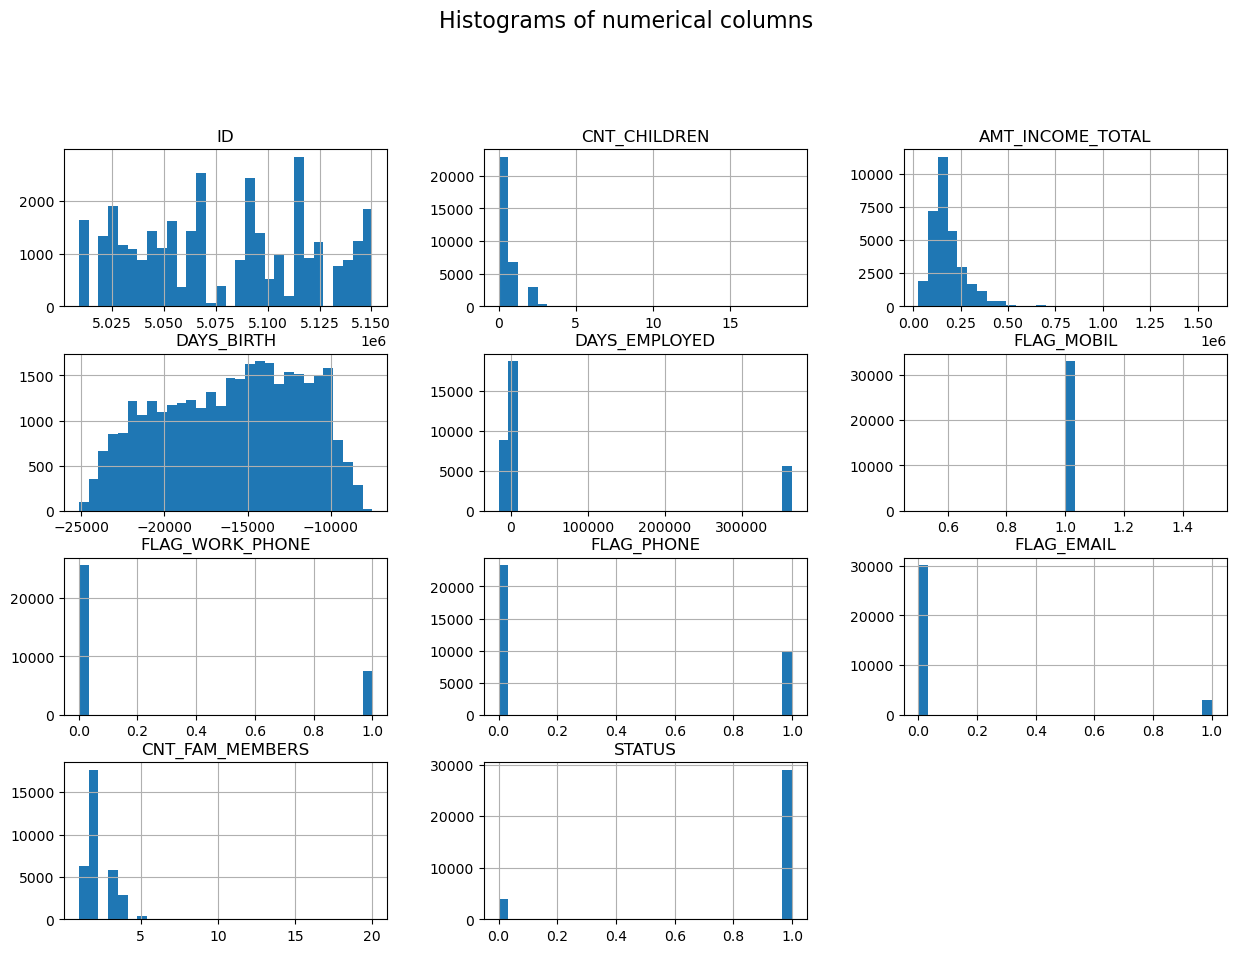

In [24]:
valid_applications.hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of numerical columns', y=1.02, size=16)
plt.show()

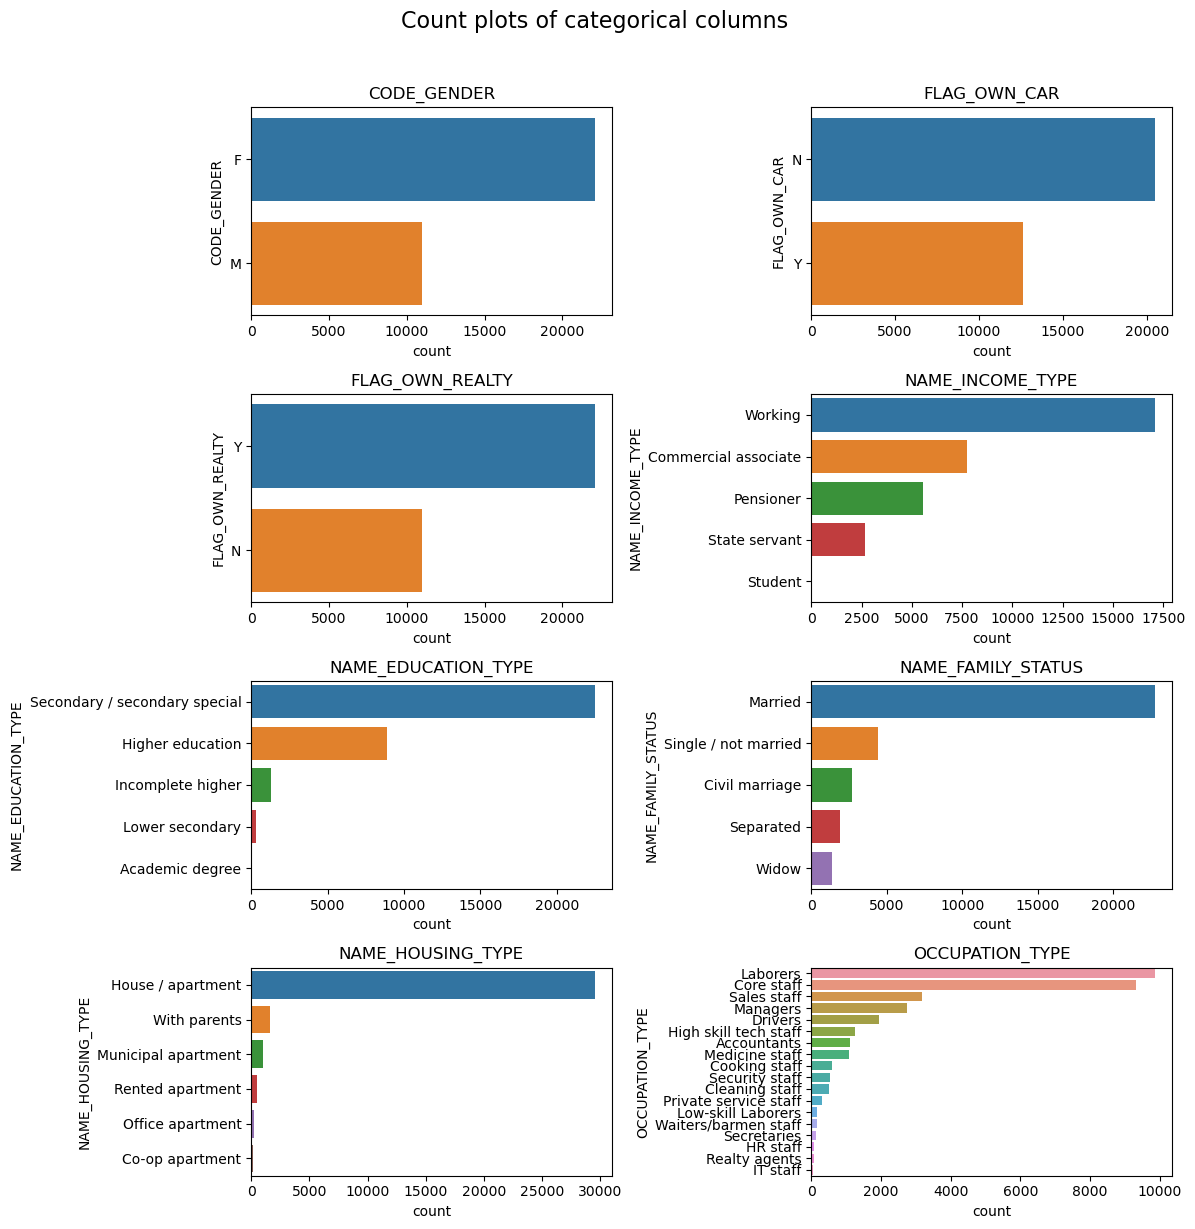

In [93]:
# plot count plot for categorical features and sort them by count
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
for i, col in enumerate(valid_applications.select_dtypes(include='object').columns):
    sns.countplot(data=valid_applications, y=col, order=valid_applications[col].value_counts().index, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(col)
    
plt.suptitle('Count plots of categorical columns', y=1.02, size=16)
plt.tight_layout()

In [26]:
# Based on the histograms and count plots, we can see that there are some columns like FLAG_MOBIL that has only one value, so we can drop them. Or ID column that is not useful for our analysis.
# As the first step, we will drop these columns: FLAG_MOBIL, FLAG_EMAIL, FLAG_PHONE, FLAG_WORK_PHONE, ID
df = valid_applications.drop(columns=['FLAG_MOBIL', 'FLAG_EMAIL', 'FLAG_PHONE', 'FLAG_WORK_PHONE', 'ID'])

In [27]:
# remove outliers in CNT_CHILDREN column
df = df[df['CNT_CHILDREN'] < 6]
df['CNT_CHILDREN'].value_counts()

CNT_CHILDREN
0    22892
1     6754
2     2950
3      394
4       55
5       17
Name: count, dtype: int64

Text(0.5, 1.0, 'Histogram of AMT_INCOME_TOTAL')

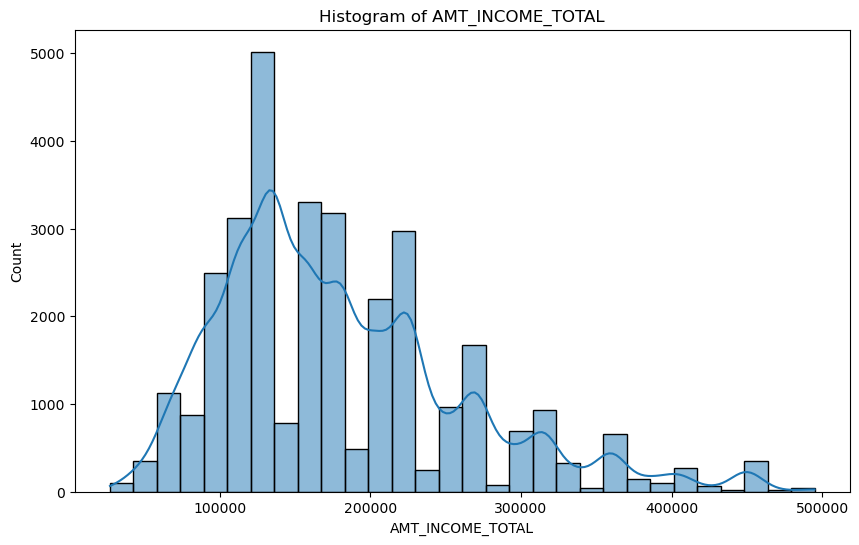

In [28]:
# remove outliers in AMT_INCOME_TOTAL column
df = df[df['AMT_INCOME_TOTAL'] < 500000]
# plot histogram for AMT_INCOME_TOTAL
plt.figure(figsize=(10, 6))
sns.histplot(df['AMT_INCOME_TOTAL'], bins=30, kde=True)
plt.title('Histogram of AMT_INCOME_TOTAL')

In [29]:
# convert DAYS_BIRTH to years
df['AGE'] = df['DAYS_BIRTH'] // -365
df = df.drop(columns='DAYS_BIRTH')

# convert DAYS_EMPLOYED to years
df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'] // -365
# replace negative values with 0
df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].apply(lambda x: 0 if x < 0 else x)
df = df.drop(columns='DAYS_EMPLOYED')

# plot of AGE vs YEARS_EMPLOYED
fig = px.scatter(df, x='AGE', y='YEARS_EMPLOYED', color='STATUS', title='Scatter plot of AGE vs YEARS_EMPLOYED')
fig.show()

Text(0.5, 1.0, 'Correlation matrix for numerical columns')

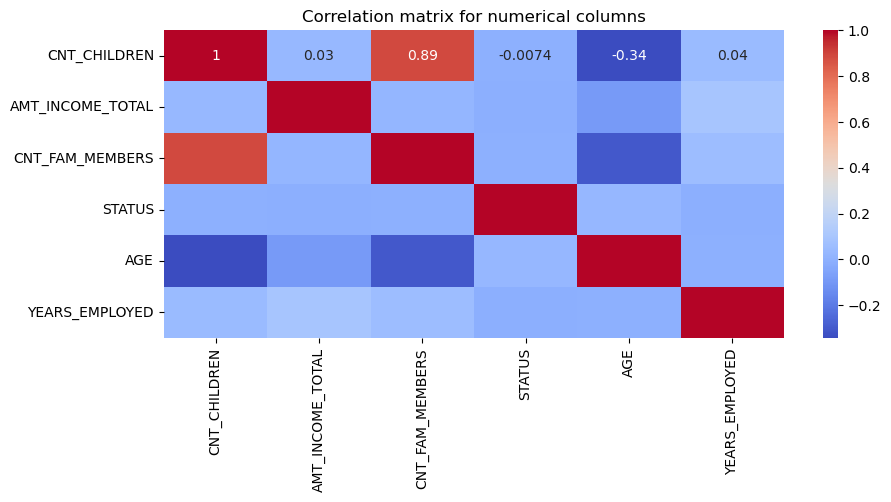

In [30]:
# plot correlation matrix for numerical values
plt.figure(figsize=(10, 4))
sns.heatmap(df.corr(numeric_only = True), annot=True, cmap='coolwarm')
plt.title('Correlation matrix for numerical columns')

Based on correlation mapping we have a high correlation between Family members and numbers of children which makes sense. There is a light correlation between number of children and age. Unfortunately there is no other strong correlation between numerical values in our dataset.

In [31]:
# remove duplicate rows
df = df.drop_duplicates()

In [32]:
# check for duplicate rows
duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')

# check for missing values 
missing_values = df.isnull().sum().sum()
print(f'Number of missing values: {missing_values}')

# print the shape of the dataframe
print(f'Shape of the dataframe: {df.shape}')

Number of duplicate rows: 0
Number of missing values: 0
Shape of the dataframe: (10703, 14)


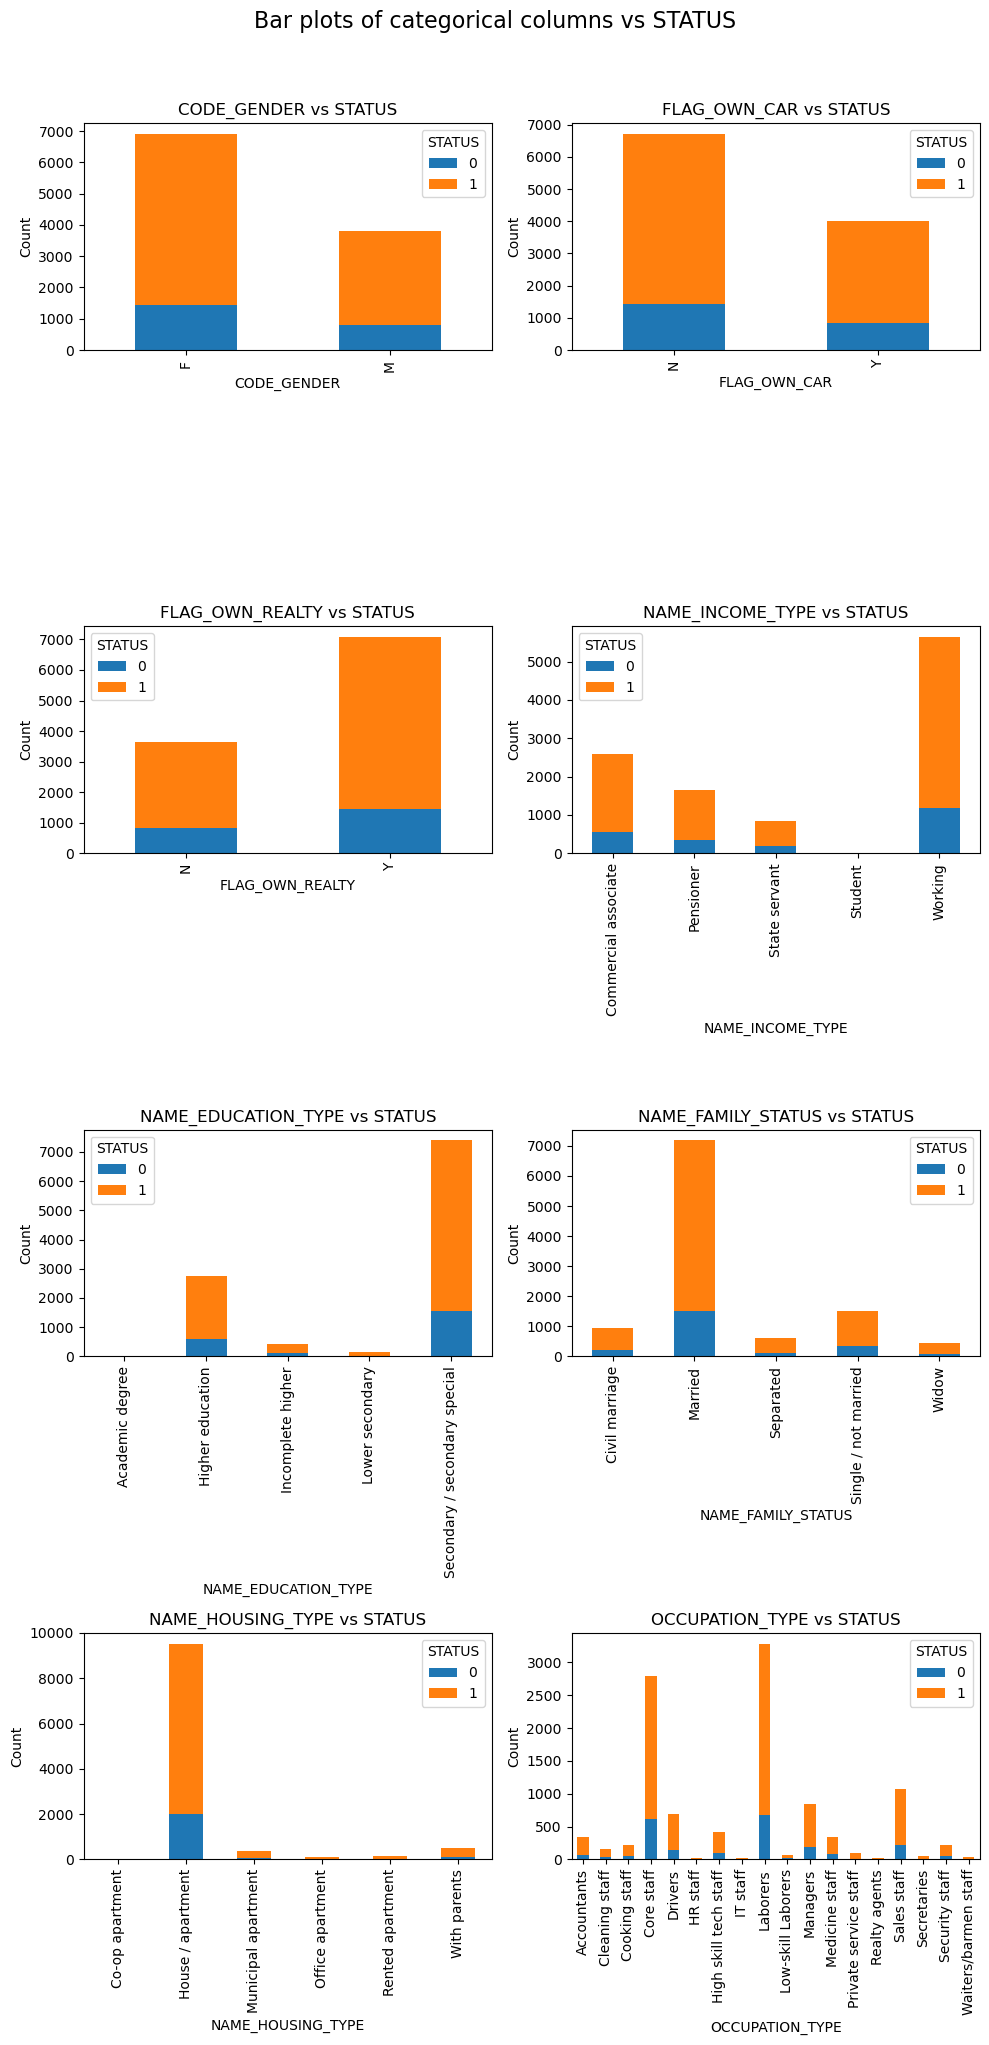

In [33]:
# do cross-tabulation for categorical columns and plot the data
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
for i, col in enumerate(df.select_dtypes(include='object').columns):
    pd.crosstab(df[col], df['STATUS']).plot(kind='bar', stacked=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{col} vs STATUS')
    axes[i//2, i%2].set_ylabel('Count')
    axes[i//2, i%2].set_xlabel(col)

plt.suptitle('Bar plots of categorical columns vs STATUS', y=1.02, size=16)
plt.tight_layout()



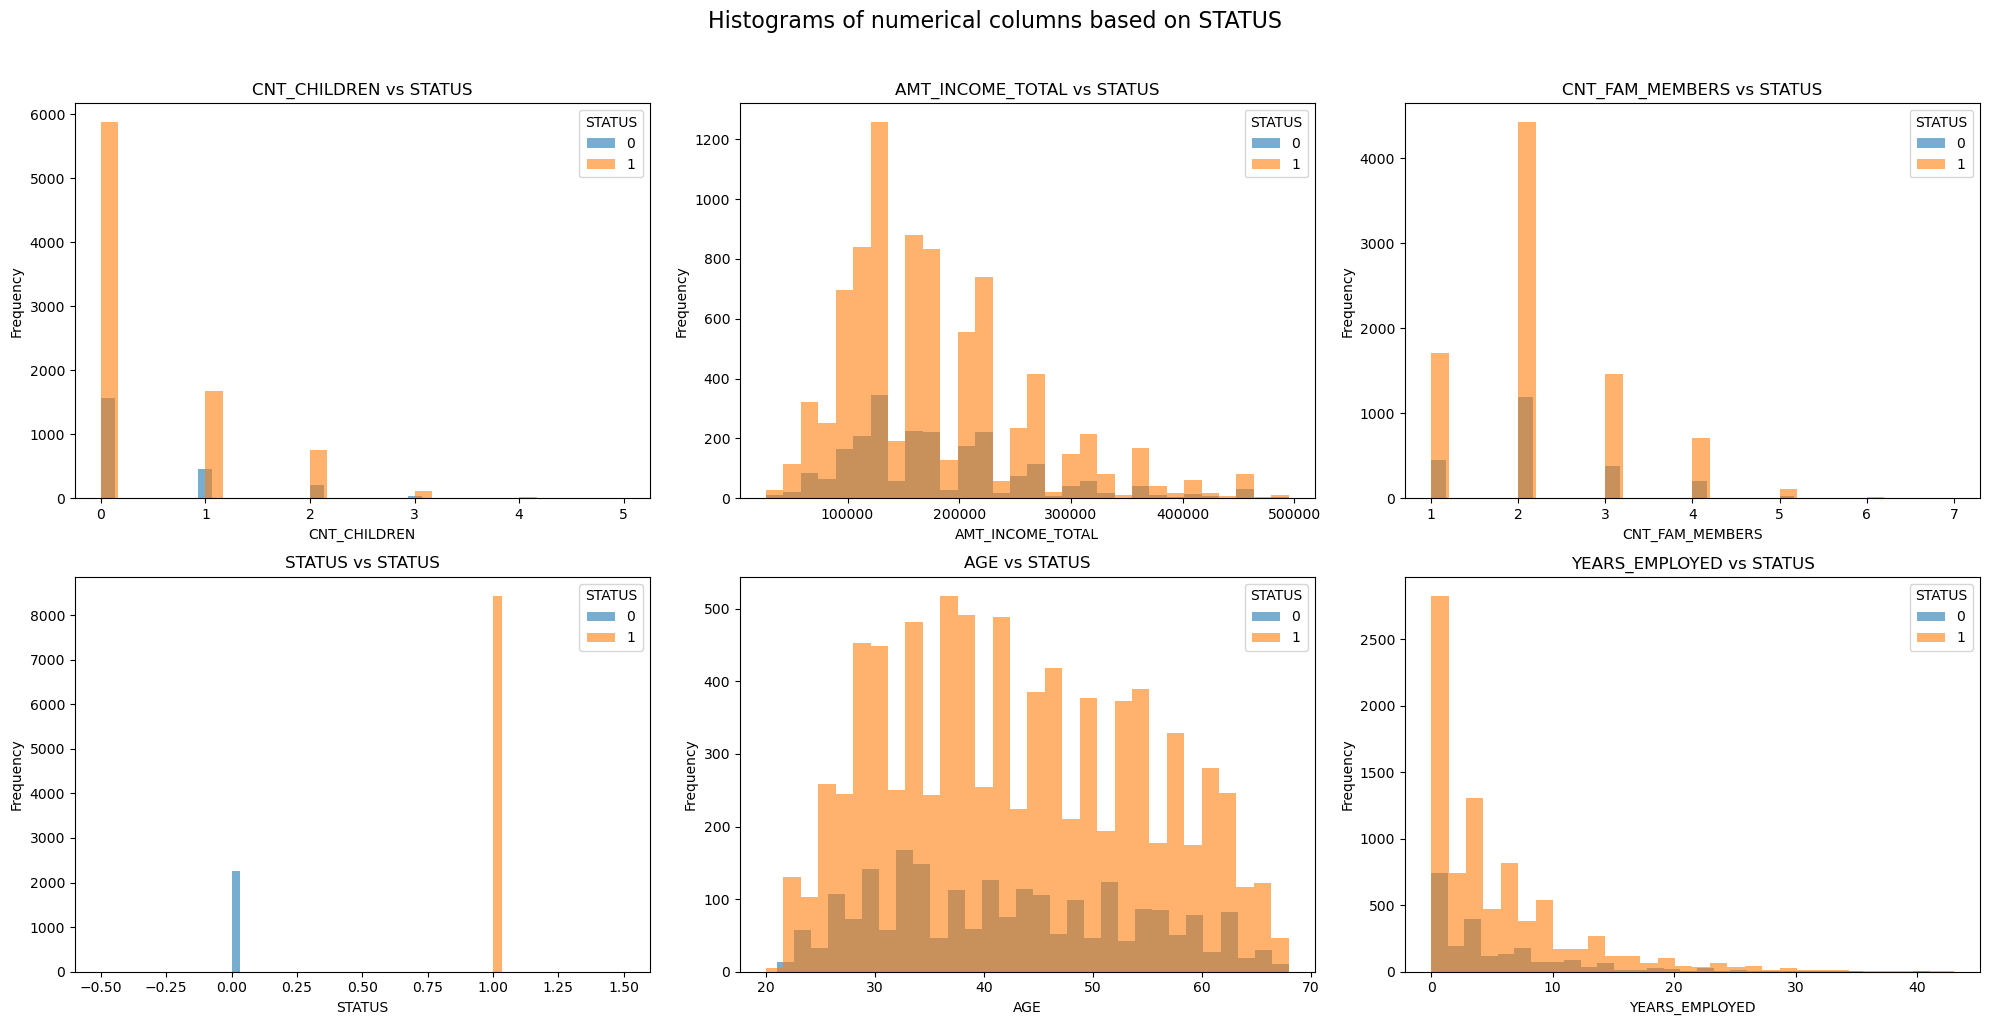

In [34]:
# plot histogram for numerical columns based on STATUS
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, col in enumerate(df.select_dtypes(exclude='object').columns):
    df.groupby('STATUS')[col].plot(kind='hist', bins=30, alpha=0.6, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'{col} vs STATUS')
    axes[i//3, i%3].set_xlabel(col)
    axes[i//3, i%3].legend(title='STATUS')
    
plt.suptitle('Histograms of numerical columns based on STATUS', y=1.02, size=16)
plt.tight_layout()

# Model selection<a id="model"></a>

### Model selection approach
1.	Define relevant performance metrics such as accuracy, precision, recall, F1 score, and ROC-AUC to evaluate the models.
2.	Establish a baseline metric, which provides a point of reference for evaluating the performance of more complex models.
3.	Split the dataset into training and testing sets to assess the models’ performance on unseen data.
4.	Train and evaluate multiple machine learning models, including:
	* K-Nearest Neighbors (KNN)
	* Logistic Regression
	* Support Vector Machine (SVM)
	* Decision Trees
	* Random Forest
	* Deep Neural Networks
5.	Compare the models’ performance using the specified metrics and visualize the results for clear comparison.
6.	Select the best-performing model based on the comparative analysis of performance metrics.
7.	Interpret the chosen model using appropriate techniques such as feature importance to ensure transparency and understanding of the model’s decision-making process.

### Relevant performance metric
From a business perspective, the most important metric for a credit card approval model should be the F1 score. This metric balances precision and recall, making it particularly valuable for credit card approval decisions where both false positives (approving an unqualified applicant) and false negatives (rejecting a qualified applicant) carry significant business implications.

#### Why the F1 Score is Critical:

1.	Precision (Positive Predictive Value): High precision means that when the model predicts an approval, it is likely to be correct. This reduces the risk of approving applicants who may default or not meet the financial criteria, thereby mitigating financial loss.
2.	Recall (Sensitivity or True Positive Rate): High recall ensures that most qualified applicants are approved, maximizing customer acquisition and satisfaction. Missing out on qualified applicants can lead to lost business opportunities.
3.	F1 Score: By balancing precision and recall, the F1 score provides a comprehensive measure of the model’s performance. It is especially useful in scenarios where the cost of false positives and false negatives are both high, as it ensures that the model maintains a good trade-off between avoiding unqualified applicants and not missing out on qualified ones.

#### Additional Considerations:

* ROC-AUC: This metric can also be important as it measures the model’s ability to discriminate between positive and negative classes across different threshold settings. A high ROC-AUC indicates a good overall performance of the model.
* Business Rules and Risk Management: Besides F1 score, integrating business-specific rules and risk management strategies into the model’s deployment phase can further refine decision-making, ensuring that the model aligns with the company’s financial risk tolerance and regulatory requirements.

By focusing on the F1 score, businesses can ensure that their credit card approval model effectively identifies qualified applicants while minimizing the risk associated with approving unqualified ones. This balanced approach is crucial for maintaining financial health and customer satisfaction.

In [36]:
# Baseline model
baseline = df['STATUS'].mean()

print(f'Baseline model accuracy: {baseline:.2%}')

Baseline model accuracy: 78.81%


In [37]:
# split the data into features and target
X = df.drop(columns='STATUS')
y = df['STATUS']

In [54]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Define categorical and numerical columns
categorical_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
numerical_features = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS', 'AGE', 'YEARS_EMPLOYED']

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop = 'if_binary', handle_unknown='ignore'), categorical_features)
    ])

In [55]:
# Initialize the models with pipelines
models = {
    'Dummy Classifier': Pipeline([('preprocessor', preprocessor), ('model', DummyClassifier(strategy='most_frequent'))]),
    'KNN': Pipeline([('preprocessor', preprocessor), ('model', KNeighborsClassifier())]),
    'Logistic Regression': Pipeline([('preprocessor', preprocessor), ('model', LogisticRegression(random_state=42))]),
    'Decision Tree': Pipeline([('preprocessor', preprocessor), ('model', DecisionTreeClassifier(random_state=42))]),
    'Random Forest': Pipeline([('preprocessor', preprocessor), ('model', RandomForestClassifier(random_state=42))]),
    'XGBoost': Pipeline([('preprocessor', preprocessor), ('model', XGBClassifier(eval_metric='logloss'))]),
    'SVM': Pipeline([('preprocessor', preprocessor), ('model', SVC(random_state=42))])
}

In [56]:
# train models
# Define the parameter grids for each model
param_grids = {
    'Dummy Classifier': {},
    'KNN': {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance']
    },
    'Logistic Regression': {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'lbfgs']
    },
    'SVM': {
        'model__C': [0.1, 1, 10, 100],
        'model__kernel': ['linear', 'rbf', 'poly'],
    },
    'Decision Tree': {
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [2, 5, 10],
        'model__min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [6, 8, 10],
        'model__learning_rate': [0.01, 0.1, 0.3],
        'model__subsample': [0.5, 0.7, 1]
    }
}

results = {}

for name, pipeline in models.items():
    print(f"Training {name}...")
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=3, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred_dev = best_model.predict(X_train)
    y_pred = best_model.predict(X_test)
    results[name] = {
        # dev set
        'Accuracy_Dev': accuracy_score(y_train, y_pred_dev),
        'Precision_Dev': precision_score(y_train, y_pred_dev),
        'Recall_Dev': recall_score(y_train, y_pred_dev),
        'F1 Score_Dev': f1_score(y_train, y_pred_dev),
        'ROC AUC_Dev': roc_auc_score(y_train, y_pred_dev),
        #test set
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred),
        'Training Time': grid_search.refit_time_,
        'Best Params': grid_search.best_params_,
        'Best Model': best_model
    }

results_df = pd.DataFrame(results).T
print(results_df)

Training Dummy Classifier...


Training KNN...
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training SVM...
                    Accuracy_Dev Precision_Dev Recall_Dev F1 Score_Dev   
Dummy Classifier        0.788951      0.788951        1.0     0.882027  \
KNN                     0.789302      0.792578   0.992746     0.881441   
Logistic Regression     0.788951      0.788951        1.0     0.882027   
Decision Tree           0.797244      0.805032   0.980459     0.884128   
Random Forest           0.788951      0.788951        1.0     0.882027   
XGBoost                 0.788951      0.788951        1.0     0.882027   
SVM                      0.79117      0.790706        1.0     0.883122   

                    ROC AUC_Dev  Accuracy Precision    Recall  F1 Score   
Dummy Classifier            0.5   0.78468   0.78468       1.0  0.879351  \
KNN                    0.510762   0.77347  0.783041  0.983929  0.872065   
Logistic Regression         0.5   0.78468   0.

In [59]:
# convert results_df metrics to numeric
results_df = results_df.apply(pd.to_numeric, errors='ignore')

In [60]:
# order the models based on F1 Score
results_df.drop(columns='Best Model').sort_values('F1 Score', ascending=False)

,Accuracy_Dev,Precision_Dev,Recall_Dev,F1 Score_Dev,ROC AUC_Dev,Accuracy,Precision,Recall,F1 Score,ROC AUC,Training Time,Best Params
SVM,0.791170,0.790706,1.000000,0.883122,0.505257,0.788417,0.787623,1.000000,0.881196,0.508677,1.949005,"{'model__C': 10, 'model__kernel': 'linear'}"
Dummy Classifier,0.788951,0.788951,1.000000,0.882027,0.500000,0.784680,0.784680,1.000000,0.879351,0.500000,0.023577,{}
Logistic Regression,0.788951,0.788951,1.000000,0.882027,0.500000,0.784680,0.784680,1.000000,0.879351,0.500000,0.036117,"{'model__C': 10, 'model__solver': 'liblinear'}"
Random Forest,0.788951,0.788951,1.000000,0.882027,0.500000,0.784680,0.784680,1.000000,0.879351,0.500000,0.132739,"{'model__max_depth': 2, 'model__min_samples_sp..."
XGBoost,0.788951,0.788951,1.000000,0.882027,0.500000,0.784680,0.784680,1.000000,0.879351,0.500000,0.211433,"{'model__learning_rate': 0.01, 'model__max_dep..."
KNN,0.789302,0.792578,0.992746,0.881441,0.510762,0.773470,0.783041,0.983929,0.872065,0.495218,0.020973,"{'model__n_neighbors': 9, 'model__weights': 'u..."
Decision Tree,0.797244,0.805032,0.980459,0.884128,0.546400,0.748716,0.779354,0.948214,0.855532,0.484953,0.042830,"{'model__max_depth': 10, 'model__min_samples_s..."


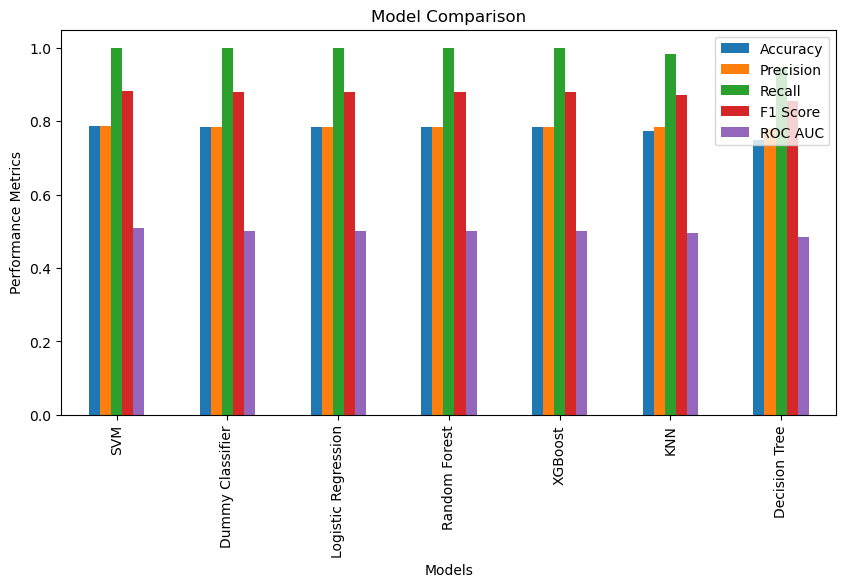

In [80]:
results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']].sort_values('F1 Score', ascending=False).plot(kind='bar', figsize=(10, 5))
plt.title('Model Comparison')
plt.ylabel('Performance Metrics')
plt.xlabel('Models')
plt.legend(loc='upper right')
plt.show()

The majority of models, including the Logistic Regression, Random Forest, and XGBoost, default to predicting the majority class, resulting in high recall but poor ROC AUC scores. The SVM model, while showing a slight improvement in ROC AUC, still demonstrates only marginal gains over the baseline. These results indicate a potential need for better feature selection or alternative modeling approaches to improve the discriminatory power of the models.

## Deep Neural Networks
As a next step, we're going to build a simple DNN model and see if a new model will be able to find any patterns in our dataset.

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

modelK = Sequential()
modelK.add(Dense(128, activation = 'relu'))
modelK.add(Dropout(0.2))
modelK.add(Dense(64, activation = 'relu'))
modelK.add(Dropout(0.2))
modelK.add(Dense(32, activation = 'relu'))
modelK.add(Dropout(0.2))
modelK.add(Dense(1, activation = 'sigmoid'))
modelK.compile(loss = 'bce', metrics = ['acc'])

preprocessor.fit(X)
X_train_trans = preprocessor.transform(X_train)
X_test_trans = preprocessor.transform(X_test)

history = modelK.fit(X_train_trans, y_train, validation_data = (X_test_trans, y_test),
           epochs = 200, verbose = 0 )

y_pred = modelK.predict(X_test_trans)
y_pred = (y_pred > 0.5).astype(int)

results = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_pred)
}

results

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step


{'Accuracy': 0.7846800560485754,
 'Precision': 0.7846800560485754,
 'Recall': 1.0,
 'F1 Score': 0.8793509552473174,
 'ROC AUC': 0.5}

In [87]:
# print Dummy Classifier results
dcr = results_df.loc['Dummy Classifier'][['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']]

#add results to dcr
comparison_df = pd.concat([dcr, pd.Series(results, name='DNN')], axis=1)
comparison_df

,Dummy Classifier,DNN
Accuracy,0.78468,0.784680
Precision,0.78468,0.784680
Recall,1.0,1.000000
F1 Score,0.879351,0.879351
ROC AUC,0.5,0.500000


The identical metrics across all performance measures for the Dummy Classifier and the Deep Neural Network indicate that the DNN, despite its complexity, is not outperforming the simplistic Dummy Classifier. This suggests that the data features are not informative enough for the model to make better-than-baseline predictions.

In summary, the results indicate that further work is needed to improve model performance, potentially through better data preprocessing, feature engineering, or more sophisticated model architectures and tuning strategies.

# Conclusion<a id="conclusion"></a>

The credit card approval prediction project aimed to develop a robust machine learning model to enhance the efficiency and accuracy of the credit card application process. Throughout the project, we evaluated multiple models, including K-Nearest Neighbors (KNN), Logistic Regression, Decision Trees, Random Forests, XGBoost, Support Vector Machines (SVM), and a Deep Neural Network (DNN), alongside a baseline Dummy Classifier.

The following key findings were observed:

1.	***Model Performance:***
    - The majority of models, including the Logistic Regression, Random Forest, XGBoost, and DNN, exhibited performance metrics identical to the Dummy Classifier. This indicates that these models defaulted to predicting the majority class, failing to provide meaningful discrimination between approved and rejected applications.
    - The SVM showed marginally better performance with a slightly higher ROC AUC, yet the improvement was not significant, suggesting limited discriminative capability.
2.	***Evaluation Metrics:***
    - The models achieved high recall (1.000) across the board, which implies a strong tendency to predict the majority class. However, the ROC AUC scores of 0.500 indicate that the models, including the more complex DNN, did not effectively differentiate between the classes.
    - Precision and F1 scores mirrored the recall due to the models’ focus on the majority class, resulting in overall performance metrics that did not exceed the baseline set by the Dummy Classifier.
3.	***Challenges and Limitations:***
    - The uniformity in performance metrics across all models suggests potential issues such as imbalanced data, insufficient feature engineering, or inadequate model tuning. These challenges may have hindered the models’ ability to learn meaningful patterns from the data.

### Recommendations and Future Work

To address the limitations encountered and improve the model’s predictive capabilities, the following recommendations are proposed:

1.	***Data Enhancement:***
    - Further exploration into the data, including feature selection, creation, and engineering, is essential to provide the models with more informative attributes that can help in distinguishing between approved and rejected applications.
2.	***Model Tuning and Selection:***
    - Conduct more extensive hyperparameter tuning, especially for complex models like XGBoost and DNNs, to optimize their performance. Consider using more advanced techniques such as ensemble learning or stacking to leverage the strengths of multiple models.
3.	***Addressing Class Imbalance:***
    - Implement strategies to handle class imbalance, such as oversampling the minority class, undersampling the majority class, or using advanced techniques like SMOTE (Synthetic Minority Over-sampling Technique) to create a more balanced training set.
4.	***Evaluation and Monitoring:***
    - Continue monitoring the model’s performance with new data and refine the model as needed. Establish a robust evaluation framework that includes metrics beyond accuracy and recall to ensure comprehensive performance assessment.

In conclusion, while the current models did not surpass the baseline set by the Dummy Classifier, this project has laid the groundwork for future improvements. By addressing the highlighted challenges and implementing the recommended strategies, we can enhance the model’s ability to make accurate and reliable predictions, ultimately optimizing the credit card approval process for better business outcomes.